# Hip Hop Vocab Per Era Analysis #

## Introduction ##
I found a dataset on [hip hop vocab](https://data.world/the-pudding/hip-hop-vocab) that I found very interesting. It contains the number of unique words an artist has employed in their lyrics (per first 35,000 words of lyrics), the artist name, and the era they belonged to. This got me wondering if there were any trends in the number of unique words for artists across eras. This project is explores that trend and tests whether it is statistically significant. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

In [2]:
data = pd.read_csv("Hip_Hop _ Vocab_Chart-Full.csv")

## Beginning of Exloratory Data Analysis ##

Going to peak at the dataset and see what the variable types are

In [3]:
data.head()

,notes,recalc,era,rapper,rapper_clean,color,words,id,source
0,NaN,2988.0,2010s,21 Savage,21 Savage,NaN,2988,21-savage,new
1,NaN,3812.0,2010s,2 Chainz,2 Chainz,NaN,4148,2chainz,poster
2,NaN,3815.0,1990s,2Pac,2Pac,west nowutang second,"3,970",2pac,site
3,NaN,3384.0,2000s,50 Cent,50 Cent,east nowutang first,"3,591",50-cent,site
4,NaN,4534.0,2010s,Ab-Soul,Ab-Soul,NaN,4534,absoul,new


In [4]:
data.dtypes

notes            object
recalc          float64
era              object
rapper           object
rapper_clean     object
color            object
words            object
id               object
source           object
dtype: object

To begin, I'm going to play around with the naming of some of these variables to my liking. [Here's why.](https://twitter.com/kanyewest/status/1018432945839673344?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E1018432945839673344&ref_url=https%3A%2F%2Fwww.channel24.co.za%2FMusic%2FNews%2Fkanye-west-doesnt-want-journalists-to-call-him-a-rapper-20180716)
[Renamed to...](https://twitter.com/kanyewest/status/1018433346668453889?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E1018433346668453889&ref_url=https%3A%2F%2Fwww.channel24.co.za%2FMusic%2FNews%2Fkanye-west-doesnt-want-journalists-to-call-him-a-rapper-20180716)

In [5]:
data.rename(index=str, columns={"rapper": "artist"}, inplace=True)
data.drop(columns=['rapper_clean', 'notes', 'color', 'source'], inplace=True)

'recalc' is 'words' column converted to float, so going to delete 'words' column and rename 'recalc' to 'words'

In [6]:
data.drop(columns=['words'], inplace=True)
data.rename(index=str, columns={"recalc": "words"}, inplace=True)
data.head()

,words,era,artist,id
0,2988.0,2010s,21 Savage,21-savage
1,3812.0,2010s,2 Chainz,2chainz
2,3815.0,1990s,2Pac,2pac
3,3384.0,2000s,50 Cent,50-cent
4,4534.0,2010s,Ab-Soul,absoul


Most interesting variables to me are which era an artist is from and the number of unique words they have in their lyrics. So I'm going to group the dataset by era and get some basic summary values.

In [7]:
data.groupby('era').agg(['count', 'mean', 'max', 'min', 'std'])

words                                          
      count         mean     max     min          std
era                                                  
1980s     8  4207.500000  4655.0  2778.0   629.695391
1990s    44  4544.704545  6390.0  2936.0   779.285200
1999s     1  4620.000000  4620.0  4620.0          NaN
2000s    50  4633.580000  7879.0  3275.0  1045.522096
2010s    57  3722.807018  5413.0  2472.0   697.193134

Because 1999s belongs in 1990s and there is only one entry, going to replace 1999s by 1990s

In [8]:
data.replace('1999s', '1990s', inplace = True)

In [9]:
data.groupby('era').agg(['count', 'mean', 'max', 'min','std'])

words                                          
      count         mean     max     min          std
era                                                  
1980s     8  4207.500000  4655.0  2778.0   629.695391
1990s    45  4546.377778  6390.0  2936.0   770.460556
2000s    50  4633.580000  7879.0  3275.0  1045.522096
2010s    57  3722.807018  5413.0  2472.0   697.193134

I can see that there is a noticable drop in number of unique words for artists in the 2010s era. Going to plot this data to better visualize this. 

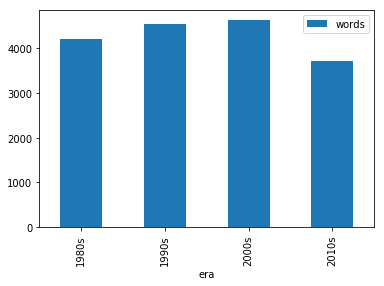

In [10]:
data.groupby('era').mean().plot.bar()

Now, the question I want to answer is, **is the drop in number of unique words in an artist's lyrics in the 2010s era statistically significant?**

To begin, what I'm essentially doing is comparing means of more than two groups. To compare the means of two groups, I could do pairwise T- tests, however, because we have 4 groups (eras), I must do a **one-way ANOVA (Analysis of Variance) test.** [For background on ANOVA.](https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide.php)

ANOVA test is used to determine whether there are any statistically significant differences among means of three or more groups. It is key to rememeber that ANOVA is an "omnibus" test, i.e it only tells us *if* the differences of two or more groups are statistically significant (but not *which* groups). To find out which groups are statistically different from the rest, some post-hoc tests must be performed.

Before I perform an ANOVA test, I must first make sure that the dataset meets **three conditions**: 
    * The dependent variable (in this case, 'words') is normally distributed -->  "Normality"
    * The variance in the data for each group are equal --> "Homoegeniety of variance"
    * "Independence of observations"

I'll perform the first 2 tests and proceed with ANOVA testing. At the end, I'll have a discussion about the "Independence of observations". 

**Checking for "Normality" condition**

To begin, I'll plot a boxplot for my data. If each group has normally distributed datapoints, then the box plots would look fairly symmetric. So I'm looking to see if any group has a boxplot that is not blatantly skewed. 

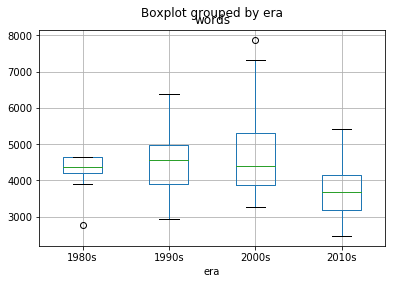

In [11]:
data[['era','words']].boxplot('words', by='era')

As it can be see, not all groups have datapoints which are normaly distributed. Datapoints in the 80s are fairly skewed and datapoints for the 00s era are quite clearly skewed to the right. This indicates that perhaps these data don't meet the required normality condition for the ANOVA test. 

A somewhat more telling test for normality is plotting a Normal Q-Q plot. 

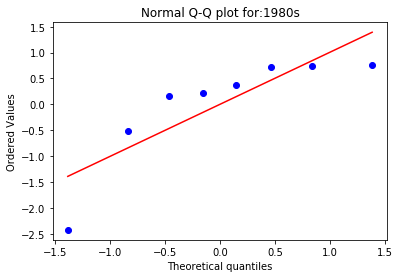

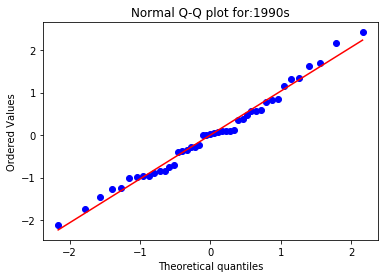

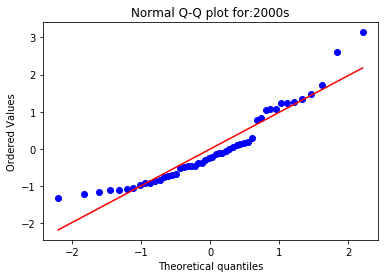

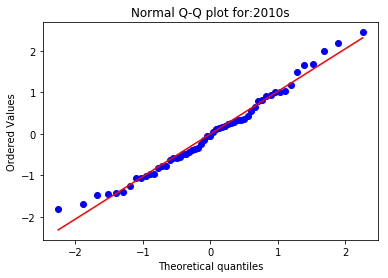

In [12]:
groups = list(data.groupby('era').groups.keys())
for group in groups:
    obs = np.array(data['words'][data['era']== group])
    z = (obs-np.mean(obs))/np.std(obs)
    stats.probplot(z, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot for:" + group)
    plt.show()
    

From these plots, it's quite clear that data from the 80s era can't be used for any statistical inference, for there are far too few datapoints in that era. Once again, datapoints from the 90s and 10s show least deviation from the normal, indicative of their underlying normal distribution - certainly more so compared to the deviation from the normal of the 00s era datapoints. 

There are more graphical tests that can be performed, such as plotting histograms, to gauge whether the data meets the normality condition. However, graphical methods are only qualitative and thus it helps to also perform some quantitative, statistical tests to check for the normality condition. 

The statistical test I'll perform to check for normality is the **Shapiro-Wilk test**. [For background on Shapiro-Wilk test.](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) The test assumes that the data is normally distributed (i.e that is its null hypothesis) and so, I'm looking for p-value to be greater than or equal 0.05 (standard), to confirm that the data is normally distributed. 

I'll use the scipy.stats.shapiro method. The return values are (test statistic, p-value)

In [13]:
for group in groups:
    print (group)
    print (stats.shapiro(data['words'][data['era'] == group]))

1980s
(0.7392493486404419, 0.006207759957760572)
1990s
(0.9846952557563782, 0.8083436489105225)
2000s
(0.9059154391288757, 0.000757816422265023)
2010s
(0.9788727760314941, 0.4170992374420166)


Once again, only the 90s and 10s era meet the normality condtion, i.e their p-value is well greater than 0.05.

From the above tests, it is clear that not all the groups have datapoints which are normally distributed. My original plan was to perform an ANOVA test, however, this must now be refined. 

The question I now want to answer is, **is the drop in the uniqueness of an artist's lyrics in the 10s era compared to artists in the 90s era, statistically significant?**

To answer this question, I'll have to compare the means of two groups, and so I'll perform a **T-test.** [Again, for background.](https://en.wikipedia.org/wiki/Student%27s_t-test)

The conditions that need to be met in order to perform a T-test are similar to the conditions for an ANOVA test. The data for the two groups must be **random, normally distributed and independent.** 

I've already checked for normality, and will assume randomness of data, given how the data was [obtained](https://pudding.cool/projects/vocabulary/). Once again, I'll leave the discussion on the independence of data for later. 

Like any other statistical test, the T-test's null hypothesis is that the difference in means is not statistically significant. Thus a p-value less 0.05 would lead one to reject the null hypothesis, implying the difference *is* statistically significant. 

Once again, I'll use scipy.stats to perform the T-test.

In [14]:
stats.ttest_ind(data['words'][data['era'] == '1990s'], data['words'][data['era'] == '2010s'])

Ttest_indResult(statistic=5.654852370186192, pvalue=1.4834503913307314e-07)

Given that the p-value is smaller than 0.05, I can safely conclude **that the drop in uniquness of words of an artist's lyrics in the 10s era compared to the 90s era is statistically significant.**

*******************

**Conclusion**

This report was not intentioned to be an ode to the "old school" hip hop artists, though 90s hip hop *is* frequently regarded as its golden era. There is so much more to a hip hop song than just it's words, such as its beats, bars, rhyme schemes and more. There is a great video by Vox on [Rapping, Deconstructed](https://www.youtube.com/watch?v=QWveXdj6oZU) that dives into what all goes into a song. But words *are* the most powerful medium a recording artist has to express themselves. The evolution from predictable single word rhymes, to multi-syllable, daisy-chained, rhymes are acredit to artists pushing the boundaries of the norm. It has given rise to some of the smoothest songs known to humankind. Artists also use their words to tell incredibly vivid stories. Stories of hardships and violence, of love and lust that has united people of all race and religion.


With this in mind, it is hard to ignore the noticable decline in vocabulary for artists in the 10s era. And it begs to question why this change has come about. Perhaps it is indicative of artists' desire to top the charts, which would require writing songs that the majority could grasp and relate to, stressing more on a catchy hook than actual substance. Perhaps every genre has exprienced this trend as it becomes mainstream. 


To conclude, it is undeniable that there is a decline in an artists vocabulary from the 90s era to the 10s era. It would, however, be blatantly wrong of me to equate this trend to the decline of hip hop. To me, this trend excites me for surely it is informing of some larger trends. Questions that interest me now are, when does a genre be considered mainstream? Is it purely the increase in volume of that genre? Or could such trends such as the decline in uniqueness be the mark of mainstream?
